## softmax回归，使用框架

In [1]:
import torch
from torch import nn
import sys
sys.path.append('..')
import utils
import d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, '../data', 4)

### 1.初始化模型参数

In [3]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状，从(batch_size, 1, 28, 28)到(batch_size, 784)
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)     # 初始化为正态分布，均值0标准差0.01

net.apply(init_weights)     # 按层应用函数

### 2.重新审视softmax

- 解决exp的上溢：
  - 在计算$softmax(\mathbf{o})$的时候，较大数值的$o_k$会导致上溢；
  - 解决办法是，在计算softmax前，将所有的输入减去最大值，即$\mathbf{o} = \mathbf{o} - argmax(\mathbf{o})$
  - 可以证明，输入数据的整体平移，并不会改变softmax的输出：
    $$
    \hat{y}_j = \frac{exp(o_j - c) exp(c)}{\sum_k{exp(o_k-c)exp(c)}} = \frac{exp(o_j - c)}{\sum_k{exp(o_k-c)}}
    $$


- 类似LogSumExp的技巧，解决$exp(o_j - argmax(\mathbf{o})) \approx 0$下溢而导致算cross entropy时$log(0)$的问题：
  - 直接使用softmax的输入，来同时计算softmax和cross entropy，而不是使用softmax的结果来算：
  $$
  \begin{aligned}
  log(\hat{y}_j) &= log\left(
    \frac{exp(o_j - argmax(\mathbf{o}))}{\sum_k{exp(o_k - argmax(\mathbf{o}))}}
    \right) \\
  &= log(exp(o_j - argmax(\mathbf{o})) - log\left(\sum_k{exp(o_k - argmax(\mathbf{o}))}\right) \\
  &= o_j - argmax(\mathbf{o}) - log\left(\sum_k{exp(o_k - argmax(\mathbf{o}))}\right)
  \end{aligned}
  $$
  - 因为我们实际上并不需要标准化后的数据，即softmax是只为CrossEntropyLoss服务的，softmax不改变网络预测的大小关系

In [4]:
loss = nn.CrossEntropyLoss()    # 这里softmax集成在了CrossEntropyLoss中了

### 3.优化器

In [5]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

### 4.评估

In [6]:
def accuracy(y_hat, y):
    '''计算预测正确的数量'''
    if len(y_hat.shape)>1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的预测准确率"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = utils.Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

### 5.训练

In [11]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = utils.Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.sum().backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()              # loss返回的是一个大小为batch_size的向量
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回本epoch的平均训练损失和平均训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [12]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = utils.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        # 逐个epoch迭代
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)     # 训练一个epoch
        test_acc = evaluate_accuracy(net, test_iter)                        # 评估测试集上的分类准确率
        animator.add(epoch + 1, train_metrics + (test_acc,))                # 这里的+是list合并，最后相当于[train_loss, train_acc, test_acc]
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

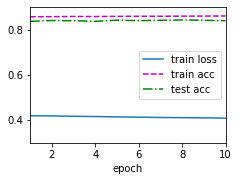

In [13]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)